## in this code we load and visualize the results from analysis of single cells (PC,TC).(figure 3 and 4 of manuscript)

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
from os.path import join
from scipy.ndimage import gaussian_filter1d
from scipy.special import factorial
from scipy.stats import spearmanr
import pftools as pf
import seaborn as sns
import pandas as pd
import mtools as mot
plt.rcParams['svg.fonttype'] = 'none'  # Export text as SVG <text> objects, not paths

mpl.rcParams['xtick.major.size'] = 6    # Length of major ticks on x-axis
mpl.rcParams['xtick.major.width'] = 1.5 # Width of major ticks on x-axis
mpl.rcParams['xtick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['xtick.major.pad'] = 10    # Padding between ticks and x-axis labels

mpl.rcParams['ytick.major.size'] = 6    # Length of major ticks on y-axis
mpl.rcParams['ytick.major.width'] = 1.5 # Width of major ticks on y-axis
mpl.rcParams['ytick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['ytick.major.pad'] = 10    # Padding between ticks and y-axis labels


# Set default spine and tick settings globally for all plots
mpl.rcParams['axes.linewidth'] = 1.5     # Set the width of all spines (top, bottom, left, right)
mpl.rcParams['xtick.major.width'] = 1.5  # Width of major ticks on x-axis
mpl.rcParams['ytick.major.width'] = 1.5  # Width of major ticks on y-axis
mpl.rcParams['xtick.labelsize'] = 12     # Font size of x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 12     # Font size of y-axis tick labels

# Define the helper function to hide spines
def hide_spines(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

Illustration of the use of these functions
 Mask indexes (burst array indexes): 
 [2, 10, 50] 
Mask indexes expanded to its 2 neighbours: 
 [ 0  1  2  3  4  8  9 10 11 12 48 49 50 51 52] 
Input indexes (array indexes of the positions y or spike positions ysp)
 [3, 7, 12, 30, 51, 100] 
Input indexes excluding those in the set of mask indexes
 [  7  30 100]


In [2]:
fs = 20# sampling freq
dt = 1/fs  # bin size of each time index
dy = 0.001 # bin size for position histogram. Since we will smooth the histogram anyways, the smaller the better (approaching Kernel Density Estimation).
sigma_y = 0.05 # I do not know the size of the animal. So, assume it to be 1% of the track.
sigma_yidx = sigma_y/dy  # Convert the position unit to unit of array index.
yedges = np.arange(0-dy/2, 1+dy, dy)  # edges for histogram
y_ax = pf.MidAx(yedges)  # position axis, mainly for plotting. Since edges are just for histogram.
allfolders2=['478','481','483','485']

In [3]:
import configparser
import os

# Initialize the configuration parser
config = configparser.ConfigParser()

# Read the configuration file
config.read('config.ini')

# Get the data folder path from the config file
savefolder= config['paths']['savefolder']


In [4]:
# In this code i load the data from outward runs and find the cells which are place cells.
#burst_len='200ms'
fol='478'
dir_of_run='L'
#celltype='PC'
celltype='Alltest_neworder'
fs = 20# sampling freq
burst_length=0.5
burst_len=str(burst_length)+'s'
burstsize=burst_length*fs# sample numbers of a burst

In [5]:
phase='learned'

In [6]:

def compute_allinfo(all_rates,P_x,r0,num_neurons):
    all_I_f = np.zeros(num_neurons)  # Forward I

    for nid in range(num_neurons):
  
        all_I_f[nid] = pf.computeSpatialInfo(all_rates[nid, :], P_x, r0[nid])
    return(all_I_f)

In [7]:
phase

'learned'

In [8]:
chosen_cell_type='all'
## Load Place cell data


allfolders2=['478','481','483','485']
#allfolders2=['485']

#allfolders2=['483']

direction=['L','R']
rate_L_R={}
PC_ratio={}

for fol1 in allfolders2:
    PC_frac_dir={}

    for dir in direction:
        cluster_pc_fractions=np.load(savefolder+fol1+'outward_'+dir+'_'+phase+'_correct_No_chunk_0.5s_transients_Alltest_neworder_with_templates_place_cell_data'+chosen_cell_type,allow_pickle=True)
       
        #cluster_pc_fractions=np.load(savefolder+fol1+'outward_'+dir+'_'+phase+'_correct_No_chunk_0.5s_transients_Alltest_neworder_with_templates_place_cell_data',allow_pickle=True)

        rate_L_R[fol1+'_'+dir]=cluster_pc_fractions#['rate_all']
        
        PC_ratio[fol1+'_'+dir]=np.sum(rate_L_R[fol1+'_'+dir]['significant'])/len(rate_L_R[fol1+'_'+dir]['significant']) # ratio of SI cells in Left and Right runs
        #Pcluster_pc_fractions['significant_ratio']

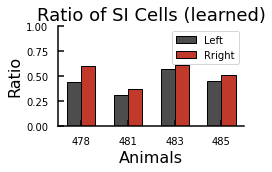

In [9]:

animals = allfolders2
L_values = [PC_ratio[f'{animal}_L'] for animal in animals]
R_values = [PC_ratio[f'{animal}_R'] for animal in animals]
colors = ['#4D4D4D', '#C0392B']

# X axis positions for L and R
x = np.arange(len(animals))  # positions for the animals
width = 0.3  # width of the bars

# Publication-ready plot size and resolution
plt.figure(figsize=(3.5, 2.5))

# Plotting using grayscale colors for publication
plt.bar(x - width/2, L_values, width, label='Left', color=colors[0], edgecolor='black')
plt.bar(x + width/2, R_values, width, label='Rright', color=colors[1], edgecolor='black')

# Adding labels, title, and legend with larger fonts for publication
plt.xlabel('Animals', fontsize=16)
plt.ylabel('Ratio', fontsize=16)
plt.title('Ratio of SI Cells ('+ phase+')', fontsize=18)
plt.xticks(x, animals, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
# Hide the top spine using plt.gca() to get the current axes
plt.gca().spines['top'].set_visible(False)

# Optionally hide the right spine as well
plt.gca().spines['right'].set_visible(False)
#plt.spines['right'].set_visible(False)
# Tight layout for better spacing
plt.tight_layout()
plt.ylim([0,1])

plt.savefig(savefolder+'SI_cell_ratio_'+phase+'.svg', format='svg')
# Save the figure in high resolution (publication-ready)
#plt.savefig('LR_Pairs_Publication_Figure.png', format='png', dpi=300)

# Show plot
plt.show()

In [12]:
## Devide Cells into PC and TC
rate_L_R_all_phases={}
cell_types_all_phases={}
for ph in ['learning','learned']:
    rate_L_R={}

    l_length={}
    r_length={}
    cell_types_all={}
    for animal_name in allfolders2:
        # cluster_pc_fractions_L=np.load(savefolder+animal_name+'outward_'+'L'+'_'+ph+'_correct_No_chunk_0.5s_transients_Alltest_neworder_with_templates_place_cell_data'+chosen_cell_type,allow_pickle=True)
        # cluster_pc_fractions_R=np.load(savefolder+animal_name+'outward_'+'R'+'_'+ph+'_correct_No_chunk_0.5s_transients_Alltest_neworder_with_templates_place_cell_data'+chosen_cell_type,allow_pickle=True)
        data = np.load(savefolder+animal_name+'Sesseion_info'+'_with_PC',allow_pickle=True)


        cluster_pc_fractions_L=data['place_cells_data'][ph]['L']
        cluster_pc_fractions_R=data['place_cells_data'][ph]['R']

        rate_L_R[animal_name+'_'+'L']=cluster_pc_fractions_L
        rate_L_R[animal_name+'_'+'R']=cluster_pc_fractions_R

        #sorted_l,sorted_r,significant_cell_idx_sorted_l = sort_clusters_cells(cluster_pc_fractions_L,cluster_pc_fractions_R)

        left_runs=cluster_pc_fractions_L['rate_all']#[cluster_pc_fractions_L['significant']]
        right_runs=cluster_pc_fractions_R['rate_all']#[cluster_pc_fractions_L['significant']]

        sig_sort_idx_l=np.argsort(np.argmax(left_runs,axis=1))
        sig_sort_idx_r=np.argsort(np.argmax(right_runs,axis=1))


        correlation_l_r,correlation_l_r_stem,similarity_between_l_and_r_all,mask_cut_l= pf.compute_corrleation(left_runs[sig_sort_idx_l],right_runs[sig_sort_idx_l])
        p_val_cells_l,mask_cut_l = pf.shuffling_rates2(cluster_pc_fractions_L,cluster_pc_fractions_R,sig_sort_idx_l)


        #sorted_r,sorted_l,significant_cell_idx_sorted_r = sort_clusters_cells(cluster_pc_fractions_R,cluster_pc_fractions_L)
        correlation_r_l,correlation_r_l_stem,similarity_between_r_and_l_all,mask_cut_r= pf.compute_corrleation(right_runs[sig_sort_idx_r],left_runs[sig_sort_idx_r])
        p_val_cells_r,mask_cut_r= pf.shuffling_rates2(cluster_pc_fractions_R,cluster_pc_fractions_L,sig_sort_idx_r)

        sig_idx_l=np.where(cluster_pc_fractions_L['significant'])[0]
        sig_idx_l_sorted = np.isin(sig_sort_idx_l, sig_idx_l)# SI and sorted l

        sig_idx_r=np.where(cluster_pc_fractions_R['significant'])[0]
        sig_idx_r_sorted = np.isin(sig_sort_idx_r, sig_idx_r)# SI and sorted r

        mask_corr_l=p_val_cells_l<0.05
        mask_corr_r=p_val_cells_r<0.05


        tc_arm_cell_l= sig_idx_l_sorted & mask_cut_l & mask_corr_l
        tc_arm_cell_r= sig_idx_r_sorted & mask_cut_r & mask_corr_r

        pc_arm_cell_l= sig_idx_l_sorted & mask_cut_l & ~mask_corr_l
        pc_arm_cell_r= sig_idx_r_sorted & mask_cut_r & ~mask_corr_r

        tc_stem_cell_l= sig_idx_l_sorted & ~mask_cut_l & mask_corr_l
        tc_stem_cell_r= sig_idx_r_sorted & ~mask_cut_r & mask_corr_r

        pc_stem_cell_l= sig_idx_l_sorted & ~mask_cut_l & ~mask_corr_l
        pc_stem_cell_r= sig_idx_r_sorted & ~mask_cut_r & ~mask_corr_r


        place_cell_vs_target_cell={}
        Cell_types_rate={}

        Cell_types_rate['TC_arm']=np.union1d(sig_sort_idx_l[tc_arm_cell_l],sig_sort_idx_r[tc_arm_cell_r])
        Cell_types_rate['PC_arm']=np.union1d(sig_sort_idx_l[pc_arm_cell_l],sig_sort_idx_r[pc_arm_cell_r])
        Cell_types_rate['TC_stem']=np.union1d(sig_sort_idx_l[tc_stem_cell_l],sig_sort_idx_r[tc_stem_cell_r])
        Cell_types_rate['PC_stem']=np.union1d(sig_sort_idx_l[pc_stem_cell_l],sig_sort_idx_r[pc_stem_cell_r])


        # Cell_types_rate['TC_arm']=(sig_sort_idx_l[tc_arm_cell_l])
        # Cell_types_rate['PC_arm']=(sig_sort_idx_l[pc_arm_cell_l])
        # Cell_types_rate['TC_stem']=(sig_sort_idx_l[tc_stem_cell_l])
        # Cell_types_rate['PC_stem']=(sig_sort_idx_l[pc_stem_cell_l])


        # pcal_SI= sig_idx_l_sorted |sig_idx_r_sorted # significant SI cells

        # mask_cut = mask_cut_l | mask_cut_l
 
        # mask_corr =  mask_corr_l | mask_corr_r # sifnificnat TC

        # target_cells_arms = mask_cut & mask_corr & pcal_SI
        # place_cells_arms = mask_cut & ~mask_corr & pcal_SI

        # target_cells_stem = ~mask_cut & mask_corr & pcal_SI
        # place_cells_stem = ~mask_cut & ~mask_corr & pcal_SI



        # Cell_types_rate['TC_arm']=np.where(target_cells_arms)[0]
        # Cell_types_rate['PC_arm']=np.where(place_cells_arms)[0]

        # Cell_types_rate['TC_stem']=np.where(target_cells_stem)[0]
        # Cell_types_rate['PC_stem']=np.where(place_cells_stem)[0]


        # Cell_types_rate['TC_arm']=significant_cell_idx_sorted[target_cells_arms]
        # Cell_types_rate['PC_arm']=significant_cell_idx_sorted[place_cells_arms]

        # Cell_types_rate['TC_stem']=significant_cell_idx_sorted[target_cells_stem]
        # Cell_types_rate['PC_stem']=significant_cell_idx_sorted[place_cells_stem]

        cell_types_all[animal_name]=Cell_types_rate
    cell_types_all_phases[ph]=cell_types_all # indices of cells that are a cell type
    rate_L_R_all_phases[ph]=rate_L_R
    
import pickle
cell_types= savefolder+'_Cell_types'

# with open(cell_types, 'wb') as file:
#     pickle.dump(cell_types_all_phases, file)


c:\Users\hamed\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\hamed\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [13]:
import copy

cell_types_all_phases_modified=copy.deepcopy(cell_types_all_phases)
for ph,phadata in cell_types_all_phases.items():
    for anm,anmdata in phadata.items():
            
            #cmncells=np.intersect1d(anmdata['PC_stem'],anmdata['PC_arm'])

            pc_tc_stem=np.intersect1d(anmdata['PC_stem'],anmdata['TC_stem'])
            pc_removed=cell_types_all_phases[ph][anm]['PC_stem'][~np.isin(cell_types_all_phases[ph][anm]['PC_stem'], pc_tc_stem)]
            cell_types_all_phases_modified[ph][anm]['PC_stem']=pc_removed


            pc_tc_arm=np.intersect1d(anmdata['PC_arm'],anmdata['TC_arm'])
            pc_removed=cell_types_all_phases[ph][anm]['PC_arm'][~np.isin(cell_types_all_phases[ph][anm]['PC_arm'], pc_tc_arm)]
            cell_types_all_phases_modified[ph][anm]['PC_arm']=pc_removed

            pc_tc_stem=np.intersect1d(cell_types_all_phases_modified[ph][anm]['PC_arm'],anmdata['TC_arm'])

            
            #cmncells=np.intersect1d(anmdata['TC_stem'],anmdata['TC_arm'])
            #cmncells=np.intersect1d(anmdata['TC_arm'],anmdata['PC_arm'])

            print(ph+anm,pc_tc_stem)


cell_types_all_phases=copy.deepcopy(cell_types_all_phases_modified)



for ph,phadata in cell_types_all_phases.items():
    for anm,anmdata in phadata.items():
            
            #cmncells=np.intersect1d(anmdata['PC_stem'],anmdata['PC_arm'])
            cmncells=np.intersect1d(anmdata['PC_stem'],anmdata['PC_arm'])
            cmncells=np.intersect1d(anmdata['TC_stem'],anmdata['TC_arm'])
            #cmncells=np.intersect1d(anmdata['TC_arm'],anmdata['PC_arm'])

            print(ph+anm,cmncells)
    


learning478 []
learning481 []
learning483 []
learning485 []
learned478 []
learned481 []
learned483 []
learned485 []


Text(0.5, 0.98, 'TC_stem')

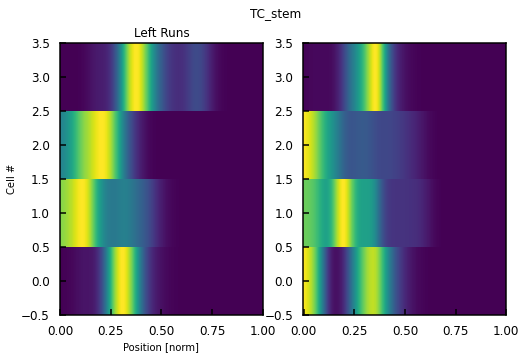

In [15]:
## Example plot cell type rate maps 

fig, (ax,ax2) = plt.subplots(1, 2,figsize=(8, 5))
typeofcelss='TC_stem'
# im = ax.pcolormesh(y_ax, np.arange(np.shape(left_runs[~mask_cut & ~mask_corr])[0]), left_runs[sig_sort_idx][~mask_cut & ~mask_corr]/np.max(np.asarray(left_runs)[sig_sort_idx][~mask_cut & ~mask_corr],axis=1)[:, np.newaxis],
#                    rasterized=True)
# Replace NaN with zero before normalization
cleaned_data = rate_L_R_all_phases['learning']['485_L']['rate_all'][cell_types_all_phases['learning']['485'][typeofcelss]]

# Normalize the data row-wise, handling cases where the max value is zero
max_values = np.max(cleaned_data, axis=1, keepdims=True)
normalized_data = np.divide(
    cleaned_data,
    max_values,
    out=np.zeros_like(cleaned_data),  # Fill with zeros where division is invalid
    where=max_values > 0  # Only divide where max_values > 0
)

# Plot the cleaned and normalized data
im = ax.pcolormesh(
    y_ax,
    np.arange(np.shape(normalized_data)[0]),
    normalized_data,
    rasterized=True,
    cmap='viridis'
)
ax.set_ylabel('Cell #')
ax.set_xlabel('Position [norm]')
#plt.colorbar(im, ax=ax)
plt.subplot(122)
ax.set_title('Left Runs')



cleaned_data =rate_L_R_all_phases['learning']['485_R']['rate_all'][cell_types_all_phases['learning']['485'][typeofcelss]]
max_values = np.max(cleaned_data, axis=1, keepdims=True)

normalized_data = np.divide(
    cleaned_data,
    max_values,
    out=np.zeros_like(cleaned_data),  # Fill with zeros where division is invalid
    where=max_values > 0  # Only divide where max_values > 0)
)
im = ax2.pcolormesh(
    y_ax,
    np.arange(np.shape(normalized_data)[0]),
    normalized_data,
    rasterized=True,
    cmap='viridis'
)

plt.suptitle(typeofcelss)

In [16]:
# get the data of all animals and compare the significant place cells of learning with learned. to see the effect of learning on pc statistics.

Compare_learning_learned_PC={'learning':{},'learned':{},'all':{}}
allfolders2=['478','481','483','485']
Rates={'learning':{},'learned':{},'all':{}}
Rates_sh={'learning':{},'learned':{},'all':{}}

#allfolders2=['485']

direction=['L','R']

phases=['learning','learned']

for phase in phases:
    rates_animal={}
    rates_sh_animal={}

    PC_fol_stats={}
    for fol1 in allfolders2:
        PC_dir_stats={}
        rate_dir={}
        rate_sh_dir={}

        for dir in direction:
            #cluster_pc_fractions=np.load(savefolder+fol1+'outward_'+dir+'_'+phase+'_correct_No_chunk_0.5s_transients_Alltest_neworder_with_templates_place_cell_data'+chosen_cell_type,allow_pickle=True)
        
            data = np.load(savefolder+fol1+'Sesseion_info'+'_with_PC',allow_pickle=True)


            #cluster_pc_fractions=np.load(savefolder+fol1+'outward_'+dir+'_'+phase+'_correct_No_chunk_0.5s_transients_Alltest_neworder_with_templates_place_cell_data',allow_pickle=True)
           # PC_dir_stats[dir]= np.sum(cluster_pc_fractions['significant'])/len(cluster_pc_fractions['significant'])
            PC_dir_stats[dir]= data['place_cells_data'][phase][dir]['significant']
            rate_dir[dir]=data['place_cells_data'][phase][dir]['rate_all']
            rate_sh_dir[dir]=data['place_cells_data'][phase][dir]['rate_all_shuffled']

            
        rates_animal[fol1]=rate_dir
        rates_sh_animal[fol1]=rate_sh_dir

        PC_fol_stats[fol1]=PC_dir_stats
    Rates[phase]=rates_animal
    Rates_sh[phase]=rates_sh_animal

    Compare_learning_learned_PC[phase]=PC_fol_stats# Masks of SI cells

In [17]:


# Get index of cell types (TC/PC)
cell_type_mask_phases={}
for ph in cell_types_all_phases.keys():

    cell_type_mask={}
    for fol in cell_types_all_phases[ph].keys():
        cell_type_mask_fol={}

        for type_indx in cell_types_all_phases[ph][fol].keys():
            mask = np.zeros_like(Compare_learning_learned_PC[ph][fol]['R'])

            mask[cell_types_all_phases[ph][fol][type_indx]]=True
            cell_type_mask_fol[type_indx]=mask
            #cell_type_mask[fol]={type_indx:mask}
        cell_type_mask[fol] = cell_type_mask_fol
    cell_type_mask_phases[ph]=cell_type_mask # make Mask of cell types

In [18]:


# Example for the 'learning' condition
learning_ratios = pf.compute_significant_ratios(cell_type_mask_phases, 'learning')
learned_ratios = pf.compute_significant_ratios(cell_type_mask_phases, 'learned')




# Compute average for learning and learned ratios
avg_learning_ratios,std_learning_ratios = pf.compute_average_ratios(learning_ratios)
avg_learned_ratios,std_learned_ratios = pf.compute_average_ratios(learned_ratios)


In [19]:


# Compute the transitions between learning and learned conditions
transitions_ratios = pf.compute_significant_transitions_new(cell_type_mask_phases)

avg_transitions_with_remained = pf.compute_average_transitions_with_remained_new(transitions_ratios)



0.22988505747126436


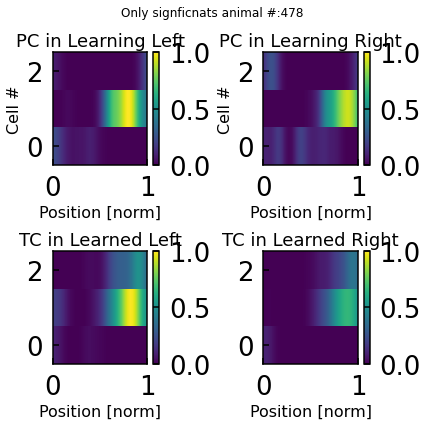

0.1111111111111111


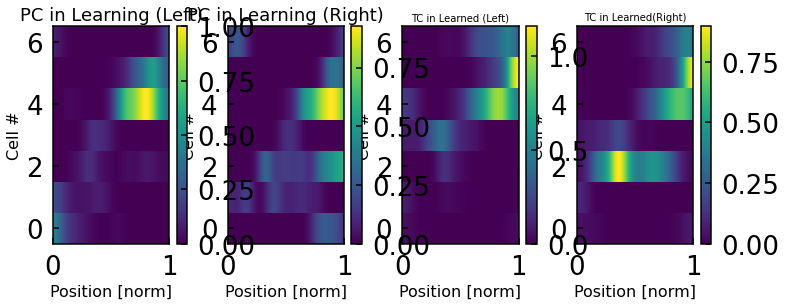

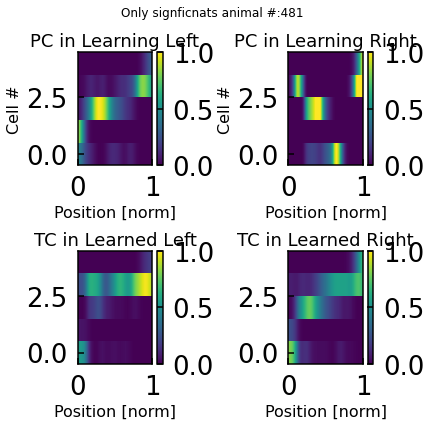

0.24731182795698925


C:\Users\hamed\AppData\Local\Temp\ipykernel_18984\955205564.py:79: RuntimeWarning: invalid value encountered in long_scalars
  PC_ratios[animal]['tc_became_non_tc']=np.sum(TC_to_Non_TC)/np.sum(TC_learning)## cells that were  TC before learning and became Non_TC after learning
C:\Users\hamed\AppData\Local\Temp\ipykernel_18984\955205564.py:84: RuntimeWarning: invalid value encountered in long_scalars
  PC_ratios[animal]['tc_became_pc']=np.sum(TC_to_PC)/np.sum(TC_learning)## cells that were  TC before learning and became Non_TC after learning
C:\Users\hamed\AppData\Local\Temp\ipykernel_18984\955205564.py:85: RuntimeWarning: invalid value encountered in long_scalars
  PC_ratios[animal]['tc_became_Non_SI']=np.sum(TC_to_Non_SI)/np.sum(TC_learning)## cells that were  TC before learning and became Non_TC after learning
C:\Users\hamed\AppData\Local\Temp\ipykernel_18984\955205564.py:86: RuntimeWarning: invalid value encountered in long_scalars
  PC_ratios[animal]['tc_became_tc_learning']=np.sum(

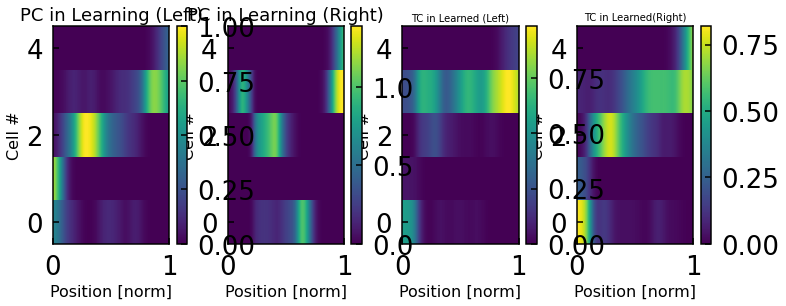

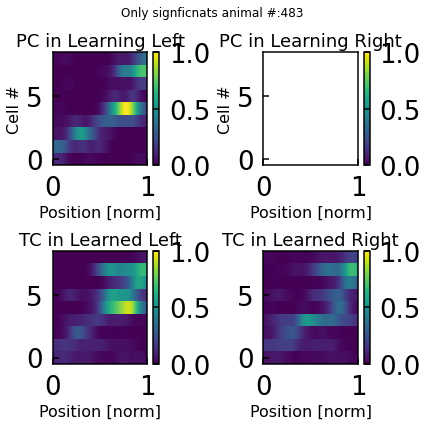

0.1559633027522936


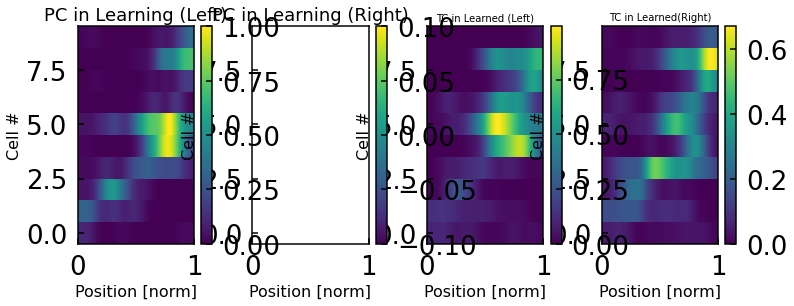

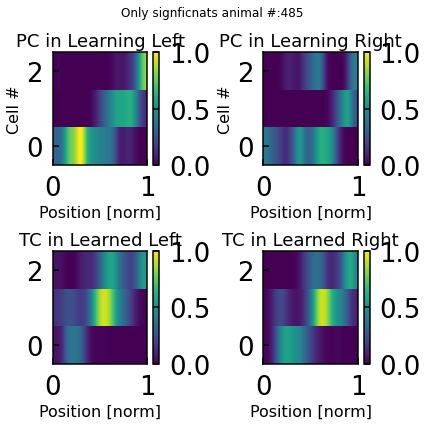

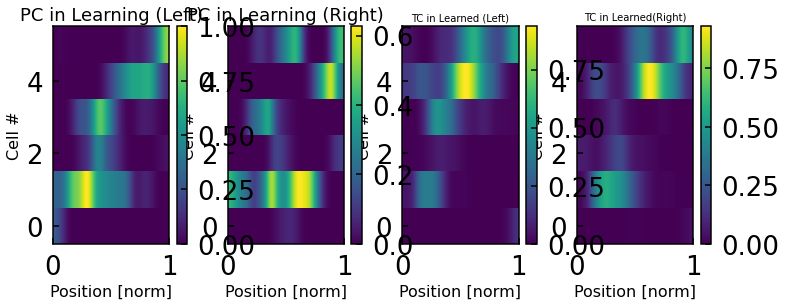

In [20]:
# Evaluate the identity of PCs that became non_PC after learning
PC_Transitions={animal:{} for animal in allfolders2}

PC_Transitions2={animal:{} for animal in allfolders2}
PC_ratios={animal:{} for animal in allfolders2}
PC_to_TC_ratios={animal:{} for animal in allfolders2}
PC_Stability={animal:{} for animal in allfolders2}
for animal in allfolders2:

    PC_learning=(cell_type_mask_phases['learning'][animal]['PC_arm'] | cell_type_mask_phases['learning'][animal]['PC_stem'])
    PC_learned=(cell_type_mask_phases['learned'][animal]['PC_arm'] | cell_type_mask_phases['learned'][animal]['PC_stem'])
    PC_to_Non_PC= PC_learning & ~PC_learned# PCs that became non_PC
    Rates['learning'][animal]

    print(np.sum(PC_to_Non_PC)/len(PC_to_Non_PC))

    TC_learning=(cell_type_mask_phases['learning'][animal]['TC_arm'] | cell_type_mask_phases['learning'][animal]['TC_stem'])
    TC_learned=(cell_type_mask_phases['learned'][animal]['TC_arm'] | cell_type_mask_phases['learned'][animal]['TC_stem'])
    TC_to_Non_TC= TC_learning & ~TC_learned
    Non_TC_to_TC= ~TC_learning & TC_learned
    TC_to_TC=TC_learning & TC_learned
    TC_to_PC= TC_learning & PC_learned

     # plt.plot(~(Compare_learning_learned_PC['learning'][animal]['R']| Compare_learning_learned_PC['learning'][animal]['L']),alpha=.5)
     # plt.plot(~(cell_type_mask_phases['learning'][animal]['PC_arm'] | cell_type_mask_phases['learning'][animal]['PC_stem'] | cell_type_mask_phases['learning'][animal]['TC_arm'] | cell_type_mask_phases['learning'][animal]['TC_stem']),alpha=.5)

    non_si_learning=~(cell_type_mask_phases['learning'][animal]['PC_arm'] | cell_type_mask_phases['learning'][animal]['PC_stem'] | cell_type_mask_phases['learning'][animal]['TC_arm'] | cell_type_mask_phases['learning'][animal]['TC_stem'])
    non_si_learned=~(cell_type_mask_phases['learned'][animal]['PC_arm'] | cell_type_mask_phases['learned'][animal]['PC_stem'] | cell_type_mask_phases['learned'][animal]['TC_arm'] | cell_type_mask_phases['learned'][animal]['TC_stem'])
    TC_to_Non_SI= TC_learning & non_si_learned

    Non_SI_learning=~PC_learning & ~TC_learning

    Non_si_became_TC=non_si_learning & TC_learned
    SI_learned = TC_learned | PC_learned


    PC_to_TC = PC_learning & TC_learned
    #PC_Transitions[animal]['PC_became_TC']= np.sum(PC_to_Non_PC & TC_learned)/len(TC_learned)# How many percent of PC turned to TC after learning.
    #PC_Transitions[animal]['PC_became_TC']= np.sum(PC_to_Non_PC & TC_learned)/np.sum(SI_learned)# How many percent of PC turned to TC after learning.


    PC_to_Non_PC_arm=(cell_type_mask_phases['learning'][animal]['PC_arm'] & ~cell_type_mask_phases['learned'][animal]['PC_arm'])
    PC_to_Non_PC_stem=(cell_type_mask_phases['learning'][animal]['PC_stem'] & ~cell_type_mask_phases['learned'][animal]['PC_stem'])

#     PC_Transitions[animal]['PC_arm_became_TC_arm']=np.sum((cell_type_mask_phases['learned'][animal]['TC_arm'] & PC_to_Non_PC_arm))/len(PC_to_Non_PC_arm)
#     PC_Transitions[animal]['PC_arm_became_TC_stem']=np.sum((cell_type_mask_phases['learned'][animal]['TC_stem'] & PC_to_Non_PC_arm))/len(PC_to_Non_PC_arm)
#     PC_Transitions[animal]['PC_stem_became_TC_arm']=np.sum((cell_type_mask_phases['learned'][animal]['TC_arm'] & PC_to_Non_PC_stem))/len(PC_to_Non_PC_stem)
#     PC_Transitions[animal]['PC_stem_became_TC_stem']=np.sum((cell_type_mask_phases['learned'][animal]['TC_stem'] & PC_to_Non_PC_stem))/len(PC_to_Non_PC_stem)

    # PC_Transitions[animal]['PC_arm_became_TC_arm']=np.sum((cell_type_mask_phases['learned'][animal]['TC_arm'] & PC_to_Non_PC_arm))/np.sum(SI_learned)
    # PC_Transitions[animal]['PC_arm_became_TC_stem']=np.sum((cell_type_mask_phases['learned'][animal]['TC_stem'] & PC_to_Non_PC_arm))/np.sum(SI_learned)
    # PC_Transitions[animal]['PC_stem_became_TC_stem']=np.sum((cell_type_mask_phases['learned'][animal]['TC_stem'] & PC_to_Non_PC_stem))/np.sum(SI_learned)
    # PC_Transitions[animal]['PC_stem_became_TC_arm']=np.sum((cell_type_mask_phases['learned'][animal]['TC_arm'] & PC_to_Non_PC_stem))/np.sum(SI_learned)

    PC_Transitions[animal]['PC_arm_became_TC_arm']=np.sum((cell_type_mask_phases['learned'][animal]['TC_arm'] & PC_to_Non_PC_arm))/np.sum(TC_learned)
    PC_Transitions[animal]['PC_arm_became_TC_stem']=np.sum((cell_type_mask_phases['learned'][animal]['TC_stem'] & PC_to_Non_PC_arm))/np.sum(TC_learned)
    PC_Transitions[animal]['PC_stem_became_TC_stem']=np.sum((cell_type_mask_phases['learned'][animal]['TC_stem'] & PC_to_Non_PC_stem))/np.sum(TC_learned)
    PC_Transitions[animal]['PC_stem_became_TC_arm']=np.sum((cell_type_mask_phases['learned'][animal]['TC_arm'] & PC_to_Non_PC_stem))/np.sum(TC_learned)



    PC_Transitions2[animal]['PC_arm_became_TC_arm']=np.sum(cell_type_mask_phases['learning'][animal]['PC_arm'] & cell_type_mask_phases['learned'][animal]['TC_arm'])/np.sum(TC_learned)
    PC_Transitions2[animal]['PC_arm_became_TC_stem']=np.sum(cell_type_mask_phases['learning'][animal]['PC_arm'] & cell_type_mask_phases['learned'][animal]['TC_stem'])/np.sum(TC_learned)

    PC_Transitions2[animal]['PC_stem_became_TC_stem']=np.sum(cell_type_mask_phases['learning'][animal]['PC_stem'] & cell_type_mask_phases['learned'][animal]['TC_stem'])/np.sum(TC_learned)
    PC_Transitions2[animal]['PC_stem_became_TC_arm']=np.sum(cell_type_mask_phases['learning'][animal]['PC_stem'] & cell_type_mask_phases['learned'][animal]['TC_arm'])/np.sum(TC_learned)


    PC_ratios[animal]['remained_pc']=np.sum((PC_learning) & (PC_learned))/np.sum(PC_learning)
    #PC_ratios[animal]['became_tc']=np.sum((PC_learning) & (PC_to_Non_PC))/np.sum(PC_learning)
    PC_ratios[animal]['became_tc']=np.sum((PC_learning) & (~PC_learned) & (TC_learned))/np.sum(PC_learning)
    PC_ratios[animal]['pc_learning']=np.sum(PC_learning)/len(PC_learning)
    # PC_ratios[animal]['non_si_became_tc']=np.sum(Non_si_became_TC)/len(PC_learning)# cells that were not SI before learning and became TC after learning
    # PC_ratios[animal]['non_tc_became_tc']=np.sum(Non_TC_to_TC)/len(PC_learning)# # cells that were not TC before learning and became TC after learning
    # PC_ratios[animal]['tc_became_non_tc']=np.sum(TC_to_Non_TC)/len(PC_learning)## cells that were  TC before learning and became Non_TC after learning

    PC_ratios[animal]['non_si_became_tc']=np.sum(Non_si_became_TC)/np.sum(TC_learned)# cells that were not SI before learning and became TC after learning
    PC_ratios[animal]['non_tc_became_tc']=np.sum(Non_TC_to_TC)/np.sum(TC_learned)# # cells that were not TC before learning and became TC after learning
    PC_ratios[animal]['tc_became_non_tc']=np.sum(TC_to_Non_TC)/np.sum(TC_learning)## cells that were  TC before learning and became Non_TC after learning
    PC_ratios[animal]['pc_became_tc']=np.sum(PC_to_TC)/np.sum(TC_learned)## cells that were  TC before learning and became Non_TC after learning
    PC_ratios[animal]['tc_became_tc']=np.sum(TC_to_TC)/np.sum(TC_learned)## cells that were  TC before learning and became Non_TC after learning


    PC_ratios[animal]['tc_became_pc']=np.sum(TC_to_PC)/np.sum(TC_learning)## cells that were  TC before learning and became Non_TC after learning
    PC_ratios[animal]['tc_became_Non_SI']=np.sum(TC_to_Non_SI)/np.sum(TC_learning)## cells that were  TC before learning and became Non_TC after learning
    PC_ratios[animal]['tc_became_tc_learning']=np.sum(TC_to_TC)/np.sum(TC_learning)## cells that were  TC before learning and became Non_TC after learning


    sig_l,sig_r,rate_pc_to_nonpc_learned_L,rate_pc_to_nonpc_learned_R,rate_pc_learning_L,rate_pc_learning_R= pf.significant_pc_to_tc(Rates,Rates_sh,TC_learned,PC_to_Non_PC,animal)

    PC_to_TC_ratios[animal]['PC_to_nonPC'] = len(sig_l)/len(PC_to_Non_PC)# ratio of cells that are PC and became NON-PC

    PC_to_TC_ratios[animal]['Left']=np.sum(sig_l)/len(sig_l)# howmany precent of PC_to_nonPC (left) became TC 
    
    PC_to_TC_ratios[animal]['right']=np.sum(sig_r)/len(sig_r)# howmany precent of PC_to_nonPC (right) became TC

    # Your existing code variables
    significant_cells = np.array(sig_l)
    if np.sum(significant_cells)==0:
         continue
    

    mpl.rcParams['axes.linewidth'] = 1.5
    mpl.rcParams['xtick.major.width'] = 1.5
    mpl.rcParams['ytick.major.width'] = 1.5
    mpl.rcParams['xtick.labelsize'] = 26
    mpl.rcParams['ytick.labelsize'] = 26
    pf.plot_pc_turnedto_tc(rate_pc_learning_L,rate_pc_learning_R,rate_pc_to_nonpc_learned_R,rate_pc_to_nonpc_learned_L,sig_l,animal,savefolder,y_ax,label='Left')



    TC_stable,PC_stable,TC_unstable,PC_unstable,Non_si=pf.significant_pc_to_tc_2(Rates,Rates_sh,TC_learned,PC_learning,PC_learned,animal,y_ax)

    PC_Stability[animal]['To Stable PC']=np.sum(PC_stable)/np.sum(PC_learning)# Ratio of PCs that are stbale PC after learning
    PC_Stability[animal]['To Stable TC']=np.sum(TC_stable)/np.sum(PC_learning)# Ratio of PCs that are stbale TC after learning

    PC_Stability[animal]['To Unstable PC']=np.sum(PC_unstable)/np.sum(PC_learning)# ratio of PCs that are nonsig after learning

    PC_Stability[animal]['To Unstable TC']=np.sum(TC_unstable)/np.sum(PC_learning)# ratio of PCs that are nonsig after learning
    PC_Stability[animal]['To Non SI']=np.sum(Non_si)/np.sum(PC_learning)# ratio of PCs that are nonsig after learning



    # Show the plot

    #plot_pc_turnedto_tc(rate_pc_learning_R,rate_pc_learning_L,rate_pc_to_nonpc_learned_L,rate_pc_to_nonpc_learned_R,sig_r,animal,label='Right')
    # sig_sort_idx_e = np.argsort(np.argmax(rate_pc_learning_L[significant_cells], axis=1))

    # # Create figure and axes
    # fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'width_ratios': [9, 9, 9]})
    # # Get max for normalization
    # max_o_e = np.max([np.max(rate_pc_learning_L[significant_cells][sig_sort_idx_e]), np.max(rate_pc_to_nonpc_learned_R[significant_cells][sig_sort_idx_e])])

    # # Plot the rate maps for PC in Learning
    # im1 = ax.pcolormesh(y_ax, np.arange(np.sum(significant_cells)), rate_pc_learning_L[significant_cells][sig_sort_idx_e] / max_o_e, rasterized=True)
    # plt.colorbar(im1, ax=ax)
    # ax.set_title('PC in Learning (Left)', fontsize=18)
    # ax.set_xlabel('Position [norm]', fontsize=16)
    # ax.set_ylabel('Cell #', fontsize=16)

    # # Plot the rate maps for Non-PC in Learned
    # im2 = ax2.pcolormesh(y_ax, np.arange(np.sum(significant_cells)), rate_pc_to_nonpc_learned_R[significant_cells][sig_sort_idx_e] / max_o_e,vmax=.1,rasterized=True)
    # plt.colorbar(im2, ax=ax2)
    # ax2.set_title('TC in Learned (Right)', fontsize=18)
    # ax2.set_xlabel('Position [norm]', fontsize=16)


    # # Plot the rate maps for Non-PC in Learned
    # im3 = ax3.pcolormesh(y_ax, np.arange(np.sum(significant_cells)), rate_pc_to_nonpc_learned_L[significant_cells][sig_sort_idx_e] / max_o_e,vmax=.5,rasterized=True)
    # plt.colorbar(im3, ax=ax3)
    # ax3.set_title('TC in Learned (Left)', fontsize=18)
    # ax3.set_xlabel('Position [norm]', fontsize=16)


    # plt.suptitle('Only signficnats animal #:' +animal)
    # plt.tight_layout()
    # plt.show()


In [21]:
def circular_shuffle(rate_map):
    shift = np.random.randint(0, rate_map.shape[0])  # Random shift value
    return np.roll(rate_map, shift)  # Circular shift



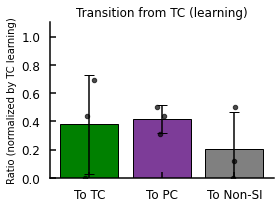

In [22]:
 # visualize ratios


# Convert data to DataFrame
df = pd.DataFrame(PC_ratios).T
colors=['green','#7D3C98','grey']

# Calculate mean and standard deviation for 'tc_became_tc', 'pc_became_tc', and 'non_si_became_tc' across all animals
mean_values = df[['tc_became_tc_learning', 'tc_became_pc', 'tc_became_Non_SI']].mean()
std_devs = df[['tc_became_tc_learning', 'tc_became_pc', 'tc_became_Non_SI']].std()

# Plotting
fig, ax = plt.subplots(figsize=(4, 3))

# Bar chart for the averages with standard deviation error bars
ax.bar(mean_values.index, mean_values, yerr=std_devs, color=colors, edgecolor='k', capsize=5, label='Mean ± SD')

# Overlay individual data points for each animal around the mean
for i, column in enumerate(['tc_became_tc_learning', 'tc_became_pc', 'tc_became_Non_SI']):
    x_positions = np.random.normal(i, 0.05, size=len(df))  # Slight jitter for clear visualization
    ax.scatter(x_positions, df[column], color='black', s=20, alpha=0.7)

# Update x-axis labels
ax.set_xticks(range(len(mean_values.index)))  # Set the number of ticks
ax.set_xticklabels(['To TC', 'To PC', 'To Non-SI'])  # New labels

# Labels and title
ax.set_ylabel('Ratio (normalized by TC learning)')
ax.set_title('Transition from TC (learning)')

# Customize spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set y-axis limits and tick parameters
plt.ylim([0, 1.1])
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5)
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_linewidth(1.5)

# Add legend
#ax.legend()

# Tight layout and show plot
for ax in [ax]:
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
plt.tight_layout()
plt.savefig(savefolder+'TC to Non_TC over TC learning new.svg', format='svg',dpi=300)
plt.show()

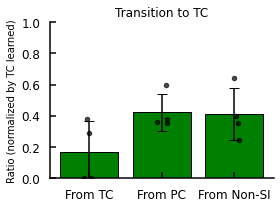

In [23]:
 # visualize ratios

# Convert data to DataFrame
df = pd.DataFrame(PC_ratios).T

# Calculate mean and standard deviation for 'tc_became_tc', 'pc_became_tc', and 'non_si_became_tc' across all animals
mean_values = df[['tc_became_tc', 'pc_became_tc', 'non_si_became_tc']].mean()
std_devs = df[['tc_became_tc', 'pc_became_tc', 'non_si_became_tc']].std()

# Plotting
fig, ax = plt.subplots(figsize=(4, 3))

# Bar chart for the averages with standard deviation error bars
ax.bar(mean_values.index, mean_values, yerr=std_devs, color='green', edgecolor='k', capsize=5, label='Mean ± SD')

# Overlay individual data points for each animal around the mean
for i, column in enumerate(['tc_became_tc', 'pc_became_tc', 'non_si_became_tc']):
    x_positions = np.random.normal(i, 0.05, size=len(df))  # Slight jitter for clear visualization
    ax.scatter(x_positions, df[column], color='black', s=20, alpha=0.7)

# Update x-axis labels
ax.set_xticks(range(len(mean_values.index)))  # Set the number of ticks
ax.set_xticklabels(['From TC', 'From PC', 'From Non-SI'])  # New labels

# Labels and title
ax.set_ylabel('Ratio (normalized by TC learned)')
ax.set_title('Transition to TC')

# Customize spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set y-axis limits and tick parameters
plt.ylim([0, 1])
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5)
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_linewidth(1.5)

# Add legend
#ax.legend()

# Tight layout and show plot
for ax in [ax]:
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
plt.tight_layout()
plt.savefig(savefolder+'Non_TC to TC over TC learned new.svg', format='svg',dpi=300)
plt.show()

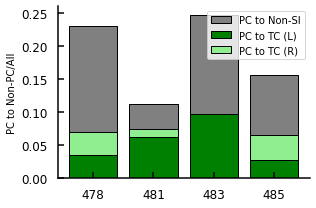

In [24]:
 # visualize ratios


# Create the plot for multiple animals
fig, ax = plt.subplots(figsize=(4.5, 3))

# Iterate over each animal
for animal, data in PC_to_TC_ratios.items():
    # Calculate the values based on 'pc_learning'
    left_value = data['Left'] * data['PC_to_nonPC']
    right_value = data['right'] * data['PC_to_nonPC']
    
    # Plot the stacked bar for each animal
    ax.bar(animal, data['PC_to_nonPC'], color='grey',label='PC to Non-SI' if animal == '478' else "",edgecolor='k' )
    ax.bar(animal, left_value, color='green', label='PC to TC (L)' if animal == '478' else "",edgecolor='k' )
    ax.bar(animal, right_value,bottom=left_value, color='lightgreen', label='PC to TC (R)' if animal == '478' else "",edgecolor='k' )

# Add labels and title
ax.set_ylabel('PC to Non-PC/All')
#ax.set_title('Proportion of Place Cells During Learning for Multiple Animals')
plt.gca().spines['top'].set_visible(False)

# Optionally hide the right spine as well
plt.gca().spines['right'].set_visible(False)
# Add a legend
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


for ax in [ax]:
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
# Show the plot
plt.tight_layout()
#plt.savefig(savefolder+'PC to Non-PC same position average.svg', format='svg')#,dpi=300)
plt.show()



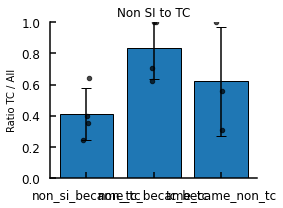

In [25]:
 # visualize ratios
# Convert data to DataFrame and select last three columns
df = pd.DataFrame(PC_ratios).T
df_last_three = df[['non_si_became_tc', 'non_tc_became_tc', 'tc_became_non_tc']]

# Calculate means and standard deviations
means = df_last_three.mean()
std_devs = df_last_three.std()

# Plotting
fig, ax = plt.subplots(figsize=(4, 3))

# Bar chart with error bars
ax.bar(means.index, means, yerr=std_devs, capsize=5, label='Mean ± SD',edgecolor='k')

# Overlay individual data points
for i, column in enumerate(df_last_three.columns):
    x_positions = np.random.normal(i, 0.05, size=len(df_last_three))
    ax.scatter(x_positions, df_last_three[column], color='black', s=20, alpha=0.7, label='Individual Data' if i == 0 else "")

# Labels and title
ax.set_ylabel('Ratio TC / All')
ax.set_title('Non SI to TC')
#ax.legend(loc='upper right')
plt.gca().spines['top'].set_visible(False)
# Optionally hide the right spine as well
plt.gca().spines['right'].set_visible(False)
# Add a legend
# Show the plot
plt.ylim([0,1])
#ax.legend( fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


for ax in [ax]:
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
plt.tight_layout()
#plt.savefig(savefolder+'Non_TC to TC over TC learned_middlebar and TC learning_rightbar.svg', format='svg',dpi=300)
plt.show()

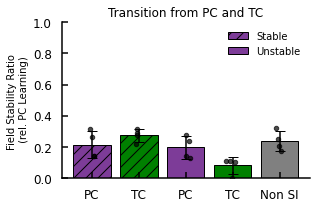

In [26]:
# # visualize ratios
# 
# 
#  Convert data to DataFrame and select last three columns
from scipy.stats import mannwhitneyu

df = pd.DataFrame(PC_Stability).T
import matplotlib.patches as mpatches
# Calculate means and standard deviations
means = df.mean()
std_devs = df.std()




# # Performing a non-parametric Mann-Whitney U test
# u_stat, p_value_pc_tc= mannwhitneyu(df['To Stable PC'], df['To Unstable TC'], alternative='two-sided')
# u_stat, p_value_tc_tc= mannwhitneyu(df['To Unstable PC'], df['To Unstable TC'], alternative='two-sided')

# u_stat, p_value_tc_tc= mannwhitneyu(df['To Stable TC'], df['To Unstable TC'], alternative='two-sided')



# Plotting
fig, ax = plt.subplots(figsize=(4.5, 3))

# Define colors and patterns for bars
colors = ['#7D3C98', 'green', '#7D3C98', 'green', 'grey']
patterns = ['//', '//',None, None,  None]  # Use patterns for unstable

# Bar chart with error bars
bars = ax.bar(means.index, means, yerr=std_devs, capsize=5, color=colors, edgecolor='k')

# Apply patterns to bars
for bar, pattern in zip(bars, patterns):
    if pattern:
        bar.set_hatch(pattern)

# Overlay individual data points
for i, column in enumerate(df.columns):
    x_positions = np.random.normal(i, 0.05, size=len(df))
    ax.scatter(x_positions, df[column], color='black', s=20, alpha=0.7)

# Adjust x-axis labels
ax.set_xticks(range(len(df.columns)))
ax.set_xticklabels(['PC', 'TC', 'PC', 'TC', 'Non SI'])

# Labels and legend
ax.set_ylabel('Field Stability Ratio \n (rel. PC Learning)')
ax.set_title('Transition from PC and TC')

# # Create legend with patterns
# stable_patch = mpatches.Patch(color='#7D3C98', label='Stable',hatch='//',edgecolor='k' )
# unstable_patch = mpatches.Patch(facecolor='#7D3C98', label='Unstable' )
# legend = ax.legend(handles=[stable_patch, unstable_patch], loc='upper right', fontsize=10, frameon=False)

import matplotlib.patches as mpatches

# Define patches for the legend
stable_patch = mpatches.Patch(facecolor='#7D3C98', edgecolor='k', hatch='//', label='Stable')
unstable_patch = mpatches.Patch(facecolor='#7D3C98', edgecolor='k', label='Unstable')

# Add the legend to the plot
legend = ax.legend(handles=[stable_patch, unstable_patch], loc='upper right', fontsize=10, frameon=False)



# Format plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim([0, 1])

for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(1.5)

ax.tick_params(axis='both', which='major', labelsize=12, width=1.5)

plt.tight_layout()

#plt.savefig(savefolder+'PC stability transition new.svg', format='svg',dpi=300)
plt.show()

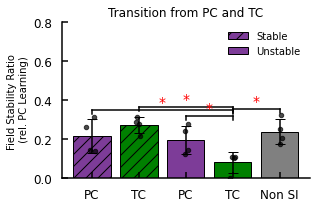

In [31]:
# Adding horizontal and vertical edge lines under stars for significant comparisons

# Calculate means and standard deviations
means = df.mean()
std_devs = df.std()
Pvals_all={}
# Compare "To Unstable TC" with all other groups
p_values = {}
for column in df.columns:
    if column != "To Unstable TC":
        stat, p = mannwhitneyu(df["To Unstable TC"], df[column], alternative='two-sided')
        p_values[column] = p



        Pvals_all[column] = {
            'stat': stat,
            'p_value': p,
            'n_group1': len(df["To Unstable TC"]),
            'n_group2': len(df[column]),
             # New variable added
        }
# Plotting
fig, ax = plt.subplots(figsize=(4.5, 3))

# Define colors and patterns for bars
colors = ['#7D3C98', 'green', '#7D3C98', 'green', 'grey']
patterns = ['//', '//', None, None, None]  # Use patterns for unstable

# Bar chart with error bars
bars = ax.bar(means.index, means, yerr=std_devs, capsize=5, color=colors, edgecolor='k')

# Apply patterns to bars
for bar, pattern in zip(bars, patterns):
    if pattern:
        bar.set_hatch(pattern)

# Overlay individual data points
for i, column in enumerate(df.columns):
    x_positions = np.random.normal(i, 0.05, size=len(df))
    ax.scatter(x_positions, df[column], color='black', s=20, alpha=0.7)

# Add significance stars, horizontal lines, and vertical line edges
for i, column in enumerate(df.columns):
    if column in p_values and p_values[column] < 0.05:
        y = max(means[column] + std_devs[column], means["To Unstable TC"] + std_devs["To Unstable TC"]) + 0.05
        ax.plot([i, 3], [y, y], color='black', linewidth=1.5)  # Horizontal line
        ax.plot([i, i], [y - 0.02, y], color='black', linewidth=1.5)  # Left vertical line
        ax.plot([3, 3], [y - 0.02, y], color='black', linewidth=1.5)  # Right vertical line
        ax.text((i + 3) / 2, y + 0.02, '*', ha='center', fontsize=14, color='red')

# Adjust x-axis labels
ax.set_xticks(range(len(df.columns)))
ax.set_xticklabels(['PC', 'TC', 'PC', 'TC', 'Non SI'])

# Labels and legend
ax.set_ylabel('Field Stability Ratio \n (rel. PC Learning)')
ax.set_title('Transition from PC and TC')

# Define patches for the legend
stable_patch = mpatches.Patch(facecolor='#7D3C98', edgecolor='k', hatch='//', label='Stable')
unstable_patch = mpatches.Patch(facecolor='#7D3C98', edgecolor='k', label='Unstable')

# Add the legend to the plot
legend = ax.legend(handles=[stable_patch, unstable_patch], loc='upper right', fontsize=10, frameon=False)

# Format plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim([0, 1.2])

for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(1.5)

ax.tick_params(axis='both', which='major', labelsize=12, width=1.5)
plt.ylim([0,.8])
plt.tight_layout()
plt.savefig(savefolder+'PC stability transition new.svg', format='svg',dpi=300)

plt.show()


In [31]:
from scipy.stats import mannwhitneyu

# Example vectors
vector1 = df['To Unstable PC']
vector2 = df['To Unstable TC']

# Perform the test
stat, p_value = mannwhitneyu(df['To Stable TC'], df['To Unstable TC'], alternative='two-sided')
#stat, p_value = mannwhitneyu(df['To Unstable PC'], df['To Unstable TC'], alternative='two-sided')

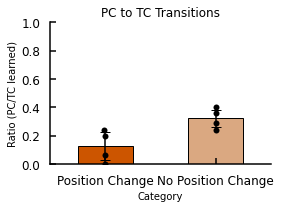

In [33]:
import numpy as np
import matplotlib.pyplot as plt

normalize_by_TC=np.mean(df_last_three['non_tc_became_tc'])

# Extract values for each transition type and pool them directly
# pooled_position_change = [
#     PC_Transitions[animal]['PC_arm_became_TC_stem'] for animal in PC_Transitions
# ] + [
#     PC_Transitions[animal]['PC_stem_became_TC_arm'] for animal in PC_Transitions
# ]
# pooled_no_position_change = [
#     PC_Transitions[animal]['PC_arm_became_TC_arm'] for animal in PC_Transitions
# ] + [
#     PC_Transitions[animal]['PC_stem_became_TC_stem'] for animal in PC_Transitions
# ]


# averages = {
#     'Position Change': np.mean(pooled_position_change),
#     'No Position Change': np.mean(pooled_no_position_change)
# }
# std_devs = {
#     'Position Change': np.std(pooled_position_change),
#     'No Position Change': np.std(pooled_no_position_change)
# }


pooled_no_position_change=[PC_Transitions[animal]['PC_arm_became_TC_arm']+PC_Transitions[animal]['PC_stem_became_TC_stem'] for animal in PC_Transitions.keys()]
pooled_position_change=[PC_Transitions[animal]['PC_arm_became_TC_stem']+PC_Transitions[animal]['PC_stem_became_TC_arm'] for animal in PC_Transitions.keys()]

averages = {
    'Position Change': np.mean(pooled_position_change),
    'No Position Change': np.mean(pooled_no_position_change)
}
std_devs = {
    'Position Change': np.std(pooled_position_change),
    'No Position Change': np.std(pooled_no_position_change)
}






# Create a DataFrame to use with Seaborn
import pandas as pd
data = pd.DataFrame({
    'Value': pooled_position_change + pooled_no_position_change,
    'Category': ['Position Change'] * len(pooled_position_change) + ['No Position Change'] * len(pooled_no_position_change)
})

# Prepare data for plotting
merged_keys = list(averages.keys())
merged_avg_values = list(averages.values())
merged_std_values = list(std_devs.values())
merged_colors = ['blue', 'green']  # Colors for the two categories
# Define a neutral color scheme (grey tones) for both categories
colors = ['#CC5500', '#DAA881']  # Light grey and dark grey
colors = ['#CC5500', '#DAA881']  # Light grey and dark grey

# Plot with adjusted bar width
plt.figure(figsize=(4, 3))
plt.bar(merged_keys, merged_avg_values, yerr=merged_std_values, capsize=5, color=colors, edgecolor='black', width=0.5)

# Overlay swarmplot
sns.swarmplot(data=data, x='Category', y='Value', color='black', size=6, edgecolor='black')



# Labels and Title
plt.ylabel('Ratio (PC/TC learned)', fontsize=10)
plt.title('PC to TC Transitions', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.gca().spines['top'].set_visible(False)

# Optionally hide the right spine as well
plt.gca().spines['right'].set_visible(False)
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim([0,1])

for ax in [ax]:
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
plt.tight_layout()
plt.savefig(savefolder+'PC to TC over TC learned new.svg', format='svg',dpi=300)
plt.show()


In [34]:

# Find cells that were active eiter in stem and arm
for ph,phadata in cell_types_all_phases.items():
    for anm,anmdata in phadata.items():
            
            #cmncells=np.intersect1d(anmdata['PC_stem'],anmdata['PC_arm'])
            pc_stem_arm=np.intersect1d(anmdata['PC_stem'],anmdata['PC_arm'])
            tc_stem_arm=np.intersect1d(anmdata['TC_stem'],anmdata['TC_arm'])

In [2]:
# Initialize an empty dictionary to store results
intersection_dict = {}

for ph, phadata in cell_types_all_phases.items():
    # Ensure there is a sub-dictionary for the phase
    intersection_dict[ph] = {}
    
    for anm, anmdata in phadata.items():
        # Compute the intersections
        pc_stem_arm = len(np.intersect1d(anmdata['PC_stem'], anmdata['PC_arm']))
        tc_stem_arm = len(np.intersect1d(anmdata['TC_stem'], anmdata['TC_arm']))
        
        # Store the results in the dictionary
        intersection_dict[ph][anm] = {
            'pc_stem_arm': pc_stem_arm,
            'tc_stem_arm': tc_stem_arm
        }
        print(anm+ph,(pc_stem_arm))
# Now intersection_dict contains both pc_stem_arm and tc_stem_arm for all phases and animals


NameError: name 'cell_types_all_phases' is not defined

In [1]:
cell_type_mask_phases

def ratio_double_counts(data,intersection_dict,cond1):        
        ratio_of_double_cells={}
        cond_mask=data[cond1][animal]['TC_arm'] | data[cond1][animal]['TC_stem'] | data[cond1][animal]['PC_arm'] | data[cond1][animal]['PC_stem']
        total_si=np.sum(cond_mask)
        for anm,anmdata in intersection_dict[cond1].items():
                anmdata['pc_stem_arm']/total_si

                ratio_of_double_cells[anm]['pc_stem_arm']= anmdata['pc_stem_arm']/total_si

NameError: name 'cell_type_mask_phases' is not defined

In [37]:
def ratio_double_counts(data, intersection_dict, cond1):        
    # Initialize the dictionary to store the ratios
    ratio_of_double_cells = {}
    
    for animal, anmdata in intersection_dict[cond1].items():
        # Calculate the mask and total SI for the current animal
        cond_mask = (
            data[cond1][animal]['TC_arm'] | 
            data[cond1][animal]['TC_stem'] | 
            data[cond1][animal]['PC_arm'] | 
            data[cond1][animal]['PC_stem']
        )
        total_si = np.sum(cond_mask)

        # Ensure the dictionary is initialized for the current animal
        ratio_of_double_cells.setdefault(animal, {})

        # Compute and store the ratios for pc_stem_arm and tc_stem_arm
        ratio_of_double_cells[animal]['pc_stem_arm'] = np.sum(anmdata['pc_stem_arm']) / total_si
        ratio_of_double_cells[animal]['tc_stem_arm'] = np.sum(anmdata['tc_stem_arm']) / total_si
    
    return ratio_of_double_cells


In [38]:
# precentage of cells that contirutied in two fieleds

learning_double_cell_ratio=ratio_double_counts(cell_type_mask_phases, intersection_dict, 'learning')
learned_double_cell_ratio=ratio_double_counts(cell_type_mask_phases, intersection_dict, 'learned')

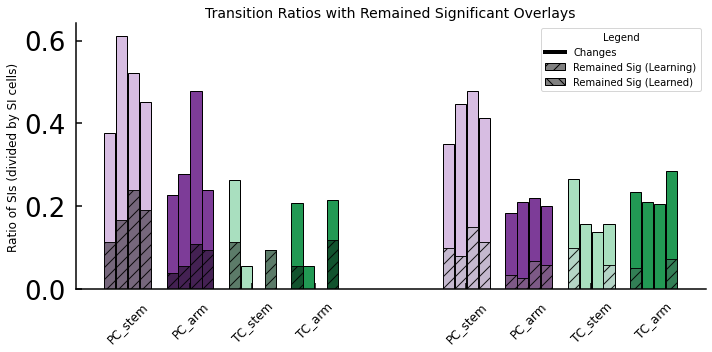

In [39]:
remained_sig_ratios_learning = {}
remained_sig_ratios_learned = {}

for animal_id, categories in transitions_ratios.items():
    remained_sig_ratios_learning[animal_id] = {}
    remained_sig_ratios_learned[animal_id] = {}
    for category, values in categories.items():
        # Grab the "Remained Sig (Learning)" and "Remained Sig (Learned)" values
        remained_sig_ratios_learning[animal_id][category] = values.get('Remained Sig (Learning)', 0)
        remained_sig_ratios_learned[animal_id][category] = values.get('Remained Sig (Learned)', 0)

# Define regions and colors
regions = ['PC_stem', 'PC_arm', 'TC_stem', 'TC_arm']
colors = ['#D7BDE2', '#7D3C98', '#A9DFBF', '#229954']
overlay_colors_learning = ['#6c5e71', '#3e1e4c', '#547060', '#114c2a']
overlay_colors_learned = ['#c4b9cd', '#7e5e85', '#b6d3c7', '#347d56']
labels = ['Learning', 'Learned']

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.15  # Width of each individual bar
tiny_gap = 0.01   # Smaller gap between each animal within the same region
group_gap = 0.2   # Reduced gap between categories within the same stage
stage_gap = 2.0   # Larger gap between the "learning" and "learned" stages

# Calculate x positions for each region and animal within each stage
x_learning = []
x_learned = []
for i, region in enumerate(regions):
    # Learning stage x positions for each animal within the region
    x_learning.extend(np.arange(len(learning_ratios)) * (bar_width + tiny_gap) + i * (len(learning_ratios) * (bar_width + tiny_gap) + group_gap))
    # Learned stage x positions, offset by stage_gap
    x_learned.extend(np.array(x_learning[-len(learning_ratios):]) + (len(regions) * len(learning_ratios) * (bar_width + tiny_gap) + stage_gap))

# Plot each region within the "learning" stage with Remained Sig overlay
for i, (region, color, overlay_color) in enumerate(zip(regions, colors, overlay_colors_learning)):
    for idx, animal in enumerate(learning_ratios.keys()):
        x = x_learning[idx + i * len(learning_ratios)]
        main_value = learning_ratios[animal][region]
        
        # Main bar
        ax.bar(x, main_value, width=bar_width, color=color, edgecolor='black', label=region if idx == 0 else "")
        
        # Remained Sig overlay (Learning)
        overlay_value_learning = remained_sig_ratios_learning[animal][region]
        ax.bar(x, overlay_value_learning, width=bar_width, color=overlay_color, edgecolor='black', alpha=0.9, hatch='//')

# Plot each region within the "learned" stage with Remained Sig overlay
for i, (region, color, overlay_color) in enumerate(zip(regions, colors, overlay_colors_learned)):
    for idx, animal in enumerate(learned_ratios.keys()):
        x = x_learned[idx + i * len(learned_ratios)]
        main_value = learned_ratios[animal][region]
        
        # Main bar
        ax.bar(x, main_value, width=bar_width, color=color, edgecolor='black')
        
        # Remained Sig overlay (Learned)
        overlay_value_learned = remained_sig_ratios_learned[animal][region]
        ax.bar(x, overlay_value_learned, width=bar_width, color=overlay_color, edgecolor='black', alpha=0.9, hatch='//')

# Customize plot
category_midpoints_learning = [np.mean(x_learning[i * len(learning_ratios):(i + 1) * len(learning_ratios)]) for i in range(len(regions))]
category_midpoints_learned = [np.mean(x_learned[i * len(learned_ratios):(i + 1) * len(learned_ratios)]) for i in range(len(regions))]
ax.set_xticks(category_midpoints_learning + category_midpoints_learned)
ax.set_xticklabels(regions * 2, fontsize=12, rotation=45)
ax.set_ylabel('Ratio of SIs (divided by SI cells)', fontsize=12)
ax.set_title('Transition Ratios with Remained Significant Overlays', fontsize=14)

# Update legend
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Define legends
solid_line = mlines.Line2D([], [], color='black', lw=4, label='Changes')
hatched_patch_learning = mpatches.Patch(facecolor='gray', edgecolor='black', hatch='//', label='Remained Sig (Learning)')
hatched_patch_learned = mpatches.Patch(facecolor='gray', edgecolor='black', hatch='\\\\', label='Remained Sig (Learned)')

# Combine into a single legend
ax.legend(handles=[solid_line, hatched_patch_learning, hatched_patch_learned], loc='upper right', title='Legend')

# Hide top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for ax in [ax]:
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
plt.tight_layout()

plt.savefig(savefolder + 'Transition_Ratios_with_Remained_Significant new.svg', dpi=300)
plt.show()


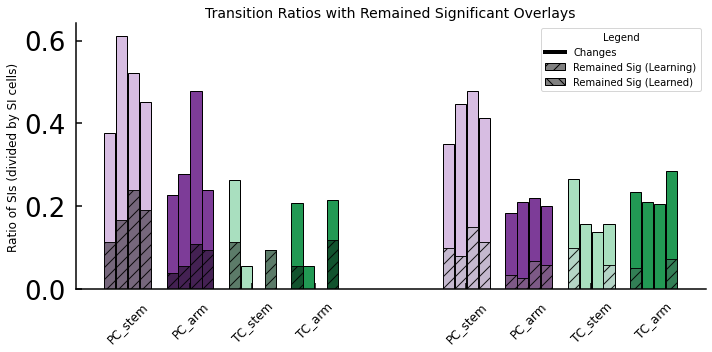

In [40]:
# Cleaned and refactored visualization code
import matplotlib.pyplot as plt
import numpy as np

def plot_transition_ratios(learning_ratios, learned_ratios, remained_sig_ratios_learning, remained_sig_ratios_learned):
    """
    Plots transition ratios for learning and learned stages with overlays for "remained significant" data.

    Parameters:
    - learning_ratios: dict, ratios for learning stage
    - learned_ratios: dict, ratios for learned stage
    - remained_sig_ratios_learning: dict, overlay data for remained significant in learning stage
    - remained_sig_ratios_learned: dict, overlay data for remained significant in learned stage
    """
    regions = ['PC_stem', 'PC_arm', 'TC_stem', 'TC_arm']
    colors = ['#D7BDE2', '#7D3C98', '#A9DFBF', '#229954']
    overlay_colors_learning = ['#6c5e71', '#3e1e4c', '#547060', '#114c2a']
    overlay_colors_learned = ['#c4b9cd', '#7e5e85', '#b6d3c7', '#347d56']
    
    # Set up figure
    fig, ax = plt.subplots(figsize=(10, 5))
    bar_width = 0.15
    tiny_gap = 0.01
    group_gap = 0.2
    stage_gap = 2.0

    # Function to calculate x-positions
    def calculate_positions(data, regions, start_offset=0):
        x_positions = []
        for i in range(len(regions)):
            x_positions.extend(
                np.arange(len(data)) * (bar_width + tiny_gap) + 
                i * (len(data) * (bar_width + tiny_gap) + group_gap) + start_offset
            )
        return x_positions

    x_learning = calculate_positions(learning_ratios, regions)
    x_learned = calculate_positions(learned_ratios, regions, start_offset=(len(regions) * len(learning_ratios) * (bar_width + tiny_gap) + stage_gap))
    
    # Function to plot bars
    def plot_bars(ax, data, x_positions, overlay_data, colors, overlay_colors, label_suffix=""):
        for i, (region, color, overlay_color) in enumerate(zip(regions, colors, overlay_colors)):
            for idx, animal in enumerate(data.keys()):
                x = x_positions[idx + i * len(data)]
                main_value = data[animal][region]
                overlay_value = overlay_data[animal][region]
                
                # Main bar
                ax.bar(x, main_value, width=bar_width, color=color, edgecolor='black', label=f"{region}{label_suffix}" if idx == 0 else "")
                # Overlay bar
                ax.bar(x, overlay_value, width=bar_width, color=overlay_color, edgecolor='black', alpha=0.9, hatch='//')

    # Plot learning and learned bars
    plot_bars(ax, learning_ratios, x_learning, remained_sig_ratios_learning, colors, overlay_colors_learning, " (Learning)")
    plot_bars(ax, learned_ratios, x_learned, remained_sig_ratios_learned, colors, overlay_colors_learned, " (Learned)")

    # Customize plot
    midpoints_learning = [np.mean(x_learning[i * len(learning_ratios):(i + 1) * len(learning_ratios)]) for i in range(len(regions))]
    midpoints_learned = [np.mean(x_learned[i * len(learned_ratios):(i + 1) * len(learned_ratios)]) for i in range(len(regions))]
    ax.set_xticks(midpoints_learning + midpoints_learned)
    ax.set_xticklabels(regions * 2, fontsize=12, rotation=45)
    ax.set_ylabel('Ratio of SIs (divided by SI cells)', fontsize=12)
    ax.set_title('Transition Ratios with Remained Significant Overlays', fontsize=14)

    # Add legend
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines
    solid_line = mlines.Line2D([], [], color='black', lw=4, label='Changes')
    hatched_patch_learning = mpatches.Patch(facecolor='gray', edgecolor='black', hatch='//', label='Remained Sig (Learning)')
    hatched_patch_learned = mpatches.Patch(facecolor='gray', edgecolor='black', hatch='\\\\', label='Remained Sig (Learned)')
    ax.legend(handles=[solid_line, hatched_patch_learning, hatched_patch_learned], loc='upper right', title='Legend')

    # Style adjustments
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_linewidth(1.5)
    plt.tight_layout()
    plt.show()

# Replace the following variables with the actual data before running the function
# learning_ratios, learned_ratios, remained_sig_ratios_learning, remained_sig_ratios_learned
plot_transition_ratios(learning_ratios, learned_ratios, remained_sig_ratios_learning, remained_sig_ratios_learned)




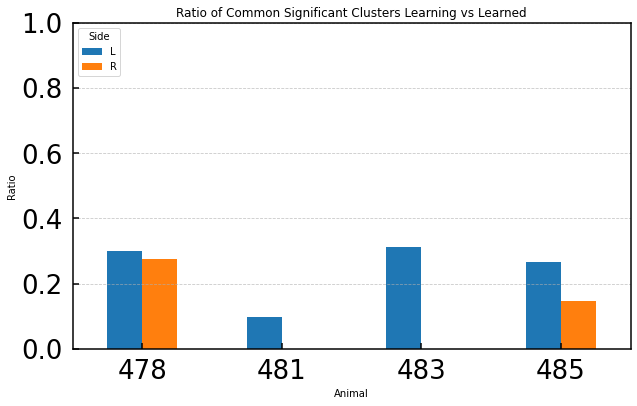

In [41]:
# Ratio of Common Significant Cells 
comm_ratio_sig_clstr,ratios_sig_clstr,PC_to_nonPC=pf.calculate_common_ratio(Compare_learning_learned_PC)

# PC transitions. Calculate averages over all animals
SI_to_nonSI_avg = {side: {key: sum(sample[side][key] for sample in PC_to_nonPC.values()) / len(PC_to_nonPC) 
              for key in ['NonPC_to_PC', 'PC_NonPC']} for side in ['L', 'R']}

# Difference Between Learned and Learning Ratios. Calculate averages over all animals
ratios_sig_avg = {state: {side: sum(sample[state][side] for sample in ratios_sig_clstr.values()) / len(ratios_sig_clstr)
                      for side in ['L', 'R']} for state in ['learning', 'learned']}



# Common significants. Calculate averages using a list comprehension
cell_type_ratios_avg = {side: sum(sample[side] for sample in comm_ratio_sig_clstr.values()) / len(comm_ratio_sig_clstr) 
                      for side in ['L', 'R']}


# Convert the data into a DataFrame for easier plotting
df_results = pd.DataFrame(comm_ratio_sig_clstr).T

# Plotting the data
ax = df_results.plot(kind='bar', figsize=(10, 6), title='Ratio of Common Significant Clusters Learning vs Learned')
ax.set_ylabel('Ratio')
ax.set_xlabel('Animal')
ax.legend(title='Side', loc='upper left')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # Set y-axis limit to ensure all bars are within the range
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

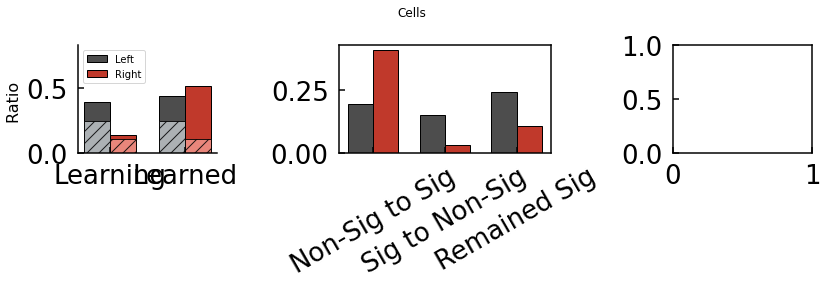

In [42]:
# Importing the required libraries for plotting
# Fancy plotting with color gradients, annotations, and improved layout
#fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 1.52]})
fig, axes = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'width_ratios': [1,1.52,1 ]})

# Colors and properties for the bars
# colors = ['#69b3a2', '#e74c3c']
# colors = ['#FF7F50', '#4682B4']

colors = ['#4D4D4D', '#C0392B']
colors2 = ['#BDC3C7', '#F1948A']

# # Bar plot for cluster_type_ratios_avg
# axes[1].bar(cell_type_ratios_avg.keys(), cell_type_ratios_avg.values(), color=colors, edgecolor='black', width=0.35)
# axes[1].set_title('Common SI Cells', fontsize=16)
# #axes[1].set_ylabel('Average (%)', fontsize=12)
# #axes[1].set_xlabel('Side', fontsize=12)
# axes[1].grid(True, axis='y', linestyle='--', alpha=0.6)

# # Convert y-axis to percentage
# axes[1].set_yticklabels([f'{int(t*100)}%' for t in axes[1].get_yticks()])


# Bar plot for ratios_sig_cluster_avg with 'Learning' and 'Learned'
learning_categories = ['Learning', 'Learned']
learning_L = [ratios_sig_avg['learning']['L'], ratios_sig_avg['learned']['L']]
learning_R = [ratios_sig_avg['learning']['R'], ratios_sig_avg['learned']['R']]

x = np.arange(len(learning_categories))  # the label locations
width = 0.35  # the width of the bars

axes[0].bar(x - width/2, learning_L, width, label='Left', color=colors[0], edgecolor='black',alpha=1)
axes[0].bar(x - width/2, cell_type_ratios_avg['L'], width,  color=colors2[0], edgecolor='black',alpha=.855, hatch='//')

axes[0].bar(x + width/2, learning_R, width, label='Right', color=colors[1], edgecolor='black',alpha=1)

axes[0].bar(x + width/2, cell_type_ratios_avg['R'], width, color=colors2[1], edgecolor='black',alpha=.855, hatch='//')

#axes[0].set_title('Ratio of SI Cells', fontsize=16)
axes[0].set_ylabel('Ratio ', fontsize=16)
axes[0].set_xticks(x)
axes[0].set_xticklabels(learning_categories)
#axes[0].grid(True, axis='y', linestyle='--', alpha=0.6)
axes[0].legend(loc='upper left',fontsize=10)
axes[0].set_ylim([0,.833])
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
# Convert y-axis to percentage
#axes[0].set_yticklabels([f'{int(t*100)}%' for t in axes[0].get_yticks()])


# Bar plot for SI_to_nonSI_cluster_avg with corrected x labels
SI_to_nonSI_categories = ['Non-Sig to Sig', 'Sig to Non-Sig','Remained Sig']
SI_L = [SI_to_nonSI_avg['L']['NonPC_to_PC'], SI_to_nonSI_avg['L']['PC_NonPC'],cell_type_ratios_avg['L']]
SI_R = [SI_to_nonSI_avg['R']['NonPC_to_PC'], SI_to_nonSI_avg['R']['PC_NonPC'],cell_type_ratios_avg['R']]

# SI_L = [SI_to_nonSI_cluster_avg['L']['NonPC_to_PC'], SI_to_nonSI_cluster_avg['L']['PC_NonPC'],cluster_type_ratios_avg['L']]
# SI_R = [SI_to_nonSI_cluster_avg['R']['NonPC_to_PC'], SI_to_nonSI_cluster_avg['R']['PC_NonPC'],cluster_type_ratios_avg['R']]



x = np.arange(len(SI_to_nonSI_categories))  # the label locations

axes[1].bar(x - width/2, SI_L, width, label='Left', color=colors[0], edgecolor='black')
axes[1].bar(x + width/2, SI_R, width, label='Right', color=colors[1], edgecolor='black')
#axes[1].set_title('Transition in SI', fontsize=16)
#axes[2].set_ylabel('Average (%)', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(SI_to_nonSI_categories,rotation=30)
#axes[1].grid(True, axis='y', linestyle='--', alpha=0.6)
#axes[1].legend(loc='upper right')

# Convert y-axis to percentage
#axes[1].set_yticklabels([f'{int(t*100)}%' for t in axes[1].get_yticks()])
plt.suptitle('Cells')

# Adjust layout and show plot
plt.tight_layout()
#plt.savefig(savefolder+'Cell_ratio.svg', format='svg',dpi=300)

plt.show()


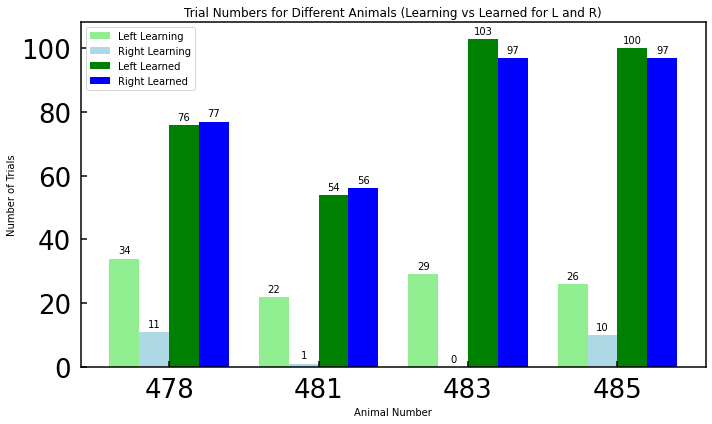

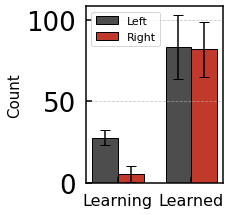

In [43]:
##Visualize the trial numbers. Comment otherwise

Trial_number={}
for fol in ['478','481','483','485']:

    #fol='483'
    dir_of_run='R'
    for dir_of_run in ['R','L']:
        for phase in ['learning','learned']:
            #celltype='PC'
            celltype='Alltest_neworder'
            fs = 20# sampling freq
            burst_length=0.5
            burst_len=str(burst_length)+'s'
            burstsize=burst_length*fs# sample numbers of a burst

            filename = fol+'outward_'+dir_of_run+'_'+phase+'_correct_No_chunk_'+burst_len+'_transients_'+celltype+'_with_templates'

            #filename = '478outward_R_all_correct_all_days_randomized_bursts_200ms_transients_allnew'

            data = np.load(join(savefolder, filename), allow_pickle=True)

            bound = [0, data['lin_pos'].shape[0]] #if turn_type == 'left' else [sepidx, endind]  

            target_cluids=np.unique(data['ids_clust'])
            Trial_number[fol+'_'+dir_of_run+'_'+phase]=len(np.unique(data['trial_idx_mask']))


# Animal numbers
animals = ['478', '481', '483', '485']

# Extracting learning and learned for both L and R for each animal
learning_R = [Trial_number[f'{animal}_R_learning'] for animal in animals]
learned_R = [Trial_number[f'{animal}_R_learned'] for animal in animals]
learning_L = [Trial_number[f'{animal}_L_learning'] for animal in animals]
learned_L = [Trial_number[f'{animal}_L_learned'] for animal in animals]

# Set positions for groups of bars
x = np.arange(len(animals))  # the label locations
width = 0.2  # the width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot learning bars for Left and Right side next to each other
bars_learning_L = ax.bar(x - width, learning_L, width, label='Left Learning', color='lightgreen')
bars_learning_R = ax.bar(x, learning_R, width, label='Right Learning', color='lightblue')

# Plot learned bars for Left and Right side next to each other, adjacent to the learning bars
bars_learned_L = ax.bar(x + width, learned_L, width, label='Left Learned', color='green')
bars_learned_R = ax.bar(x + 2 * width, learned_R, width, label='Right Learned', color='blue')

# Adding title and labels
ax.set_title('Trial Numbers for Different Animals (Learning vs Learned for L and R)')
ax.set_xlabel('Animal Number')
ax.set_ylabel('Number of Trials')

# Adding x-axis labels with ticks at the center of the groups
ax.set_xticks(x + width / 2)
ax.set_xticklabels(animals)

# Adding value labels on top of each bar
for bars in [bars_learning_L, bars_learning_R, bars_learned_L, bars_learned_R]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Adding legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()



import matplotlib.pyplot as plt
import numpy as np

colors = ['#FF7F50', '#4682B4']

# Organize data by condition
R_learning = [value for key, value in Trial_number.items() if 'R_learning' in key]
R_learned = [value for key, value in Trial_number.items() if 'R_learned' in key]
L_learning = [value for key, value in Trial_number.items() if 'L_learning' in key]
L_learned = [value for key, value in Trial_number.items() if 'L_learned' in key]


# Calculate averages
std_R_learning = np.std(R_learning)
std_R_learned = np.std(R_learned)
std_L_learning = np.std(L_learning)
std_L_learned = np.std(L_learned)


# Calculate averages
avg_R_learning = np.mean(R_learning)
avg_R_learned = np.mean(R_learned)
avg_L_learning = np.mean(L_learning)
avg_L_learned = np.mean(L_learned)

# Plot the averages using grouped bars
labels = ['Learning', 'Learned']
right_side = [avg_R_learning, avg_R_learned]
left_side = [avg_L_learning, avg_L_learned]


right_side_std = [std_R_learning, std_R_learned]
left_side_std = [std_L_learning, std_L_learned]

x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(3.3,3.1))
colors = ['#4D4D4D', '#C0392B']
# Plot the bars: Learning (Right and Left), Learned (Right and Left)
bars2 = ax.bar(x - width/2, left_side,yerr=left_side_std,  capsize=5,width=width, label='Left', color=colors[0], edgecolor='black')
bars1 = ax.bar(x + width/2, right_side,yerr=right_side_std, capsize=5, width=width, label='Right', color=colors[1], edgecolor='black')

# Adding labels, title, and custom ticks
ax.set_ylabel('Count',fontsize=15)
#ax.set_title('Average Trial Number')
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=16)
ax.legend(fontsize=11)

# # Optional: Add values on top of bars for clarity
# def add_labels(bars):
#     for bar in bars:
#         height = bar.get_height()
#         ax.annotate(f'{height:.1f}',
#                     xy=(bar.get_x() + bar.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# add_labels(bars1)
# add_labels(bars2)

# Use a grid for better visualization
ax.grid(True, linestyle='--', axis='y', alpha=0.7)

# Tight layout to avoid clipping
fig.tight_layout()

# Show the plot
plt.show()

In [44]:
# Function to merge arrays in dictionaries. merging pc fraction of all animals
def merge_values(merged_dict, new_dict):
    for key, value in new_dict.items():
        if isinstance(value, dict):
            # If the value is a dictionary, merge recursively
            merged_dict[key] = merge_values(merged_dict.get(key, {}), value)
        elif isinstance(value, np.ndarray):
            # If the value is an array, concatenate the arrays
            if key in merged_dict:
                merged_dict[key] = np.concatenate((merged_dict[key], value))
            else:
                merged_dict[key] = value
        else:
            merged_dict[key] = value  # Handle other types if needed
    return merged_dict

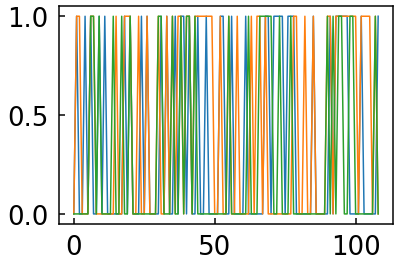

In [45]:
plt.plot(PC_learned)
plt.plot(rate_L_R[fol1+'_L']['significant'])
plt.plot(PC_learning)


c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3848: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cond_seqs[tsk]=np.asarray(sess_info['seqs'])[mskcnd & correct_mask & ph_mask]
c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3862: RuntimeWarning: invalid value encountered in long_scalars
  pc_seq_ratio[iseq]=(np.sum(np.isin(seq,sig_pc_idx))/len(sig_pc_idx[0]))# how many precent of the place cells conributed in this sequence
C:\Users\hamed\AppData\Local\Temp\ipykernel_15556\3631207098.py:96: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(data=filtered_data_merged, ax=ax, palette=first_four_colors, notch=True, width=0.6)
C:\Users\hamed\AppData\Local\Temp\ipykernel_15556\3631207098.py:96: UserWar

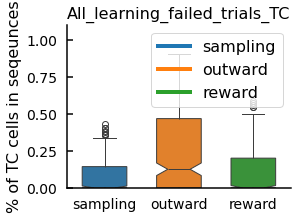

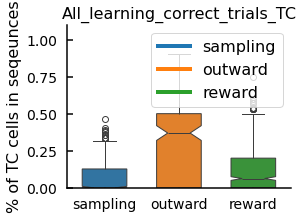

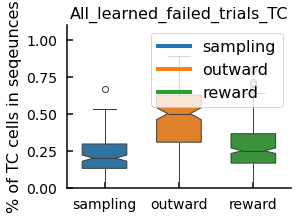

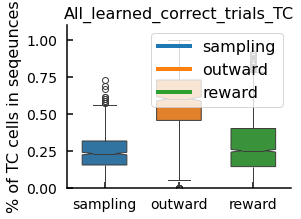

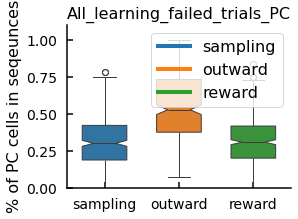

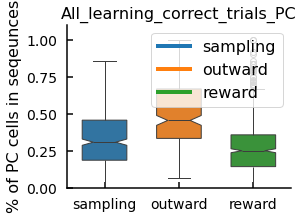

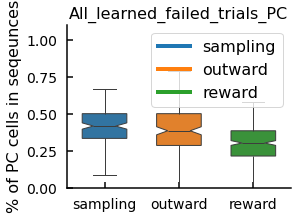

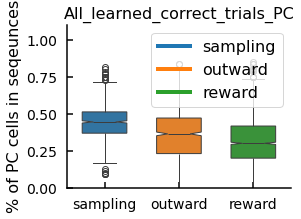

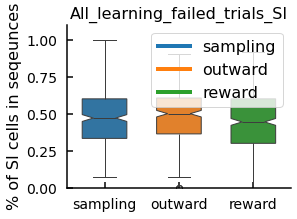

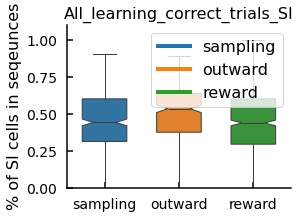

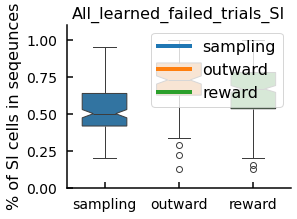

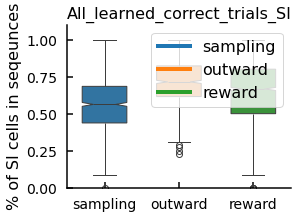

In [46]:
#dict_list.append(pc_frac)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 14  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 14  # You can adjust the font size as needed

from deepmerge import Merger
#choose_cell_type='TC'# choose the the cell type you want to see its contribution in sequences (options: PC,TC,SI)
plot_idividual_animals=False
# Initialize an empty dictionary for the final result


conds=['sampling_L',
 'sampling_R',
 'outward_L',
 'outward_R',
 'reward_L',
 'reward_R',
 'inward_L',
 'inward_R']

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Get the first four colors
first_four_colors = color_cycle[:4]


cond_number = dict(zip(conds, np.arange(len(conds))))# make mask values for each task
cond_names=cond_number
PC_seq_precent = {}

for choose_cell_type in ['TC','PC','SI']:# check the precentage of contribution of all cell types in sequences
    merged_dict = {}
    for fol1 in allfolders2:

        TC_learning=(cell_type_mask_phases['learning'][fol1]['TC_arm'] | cell_type_mask_phases['learning'][fol1]['TC_stem'])
        TC_learned=(cell_type_mask_phases['learned'][fol1]['TC_arm'] | cell_type_mask_phases['learned'][fol1]['TC_stem'])

        PC_learning=(cell_type_mask_phases['learning'][fol1]['PC_arm'] | cell_type_mask_phases['learning'][fol1]['PC_stem'])
        PC_learned=(cell_type_mask_phases['learned'][fol1]['PC_arm'] | cell_type_mask_phases['learned'][fol1]['PC_stem'])

        SI_learning=np.where(rate_L_R_all_phases['learning'][fol1+'_L']['significant']|rate_L_R_all_phases['learning'][fol1+'_R']['significant'])
        SI_learned=np.where(rate_L_R_all_phases['learned'][fol1+'_L']['significant']|rate_L_R_all_phases['learned'][fol1+'_R']['significant'])
        SI_all=np.where(rate_L_R_all_phases['learned'][fol1+'_L']['significant']|rate_L_R_all_phases['learned'][fol1+'_R']['significant'])


        cell_type_indx={}
        cell_type_indx['PC']={'learning':np.where(PC_learning),'learned':np.where(PC_learned)}

        cell_type_indx['TC']={'learning':np.where(TC_learning),'learned':np.where(TC_learned)}

        cell_type_indx['SI']={'learning':np.where(SI_learning),'learned':np.where(SI_learned),'All':np.where(SI_all)}


        sig_pc_idx=cell_type_indx[choose_cell_type]






        sessinfo_and_mask=np.load(savefolder+fol1+'Sesseion_info_All AllNo_chunk_0.5s_transients',allow_pickle=True)

        #sig_pc_idx=np.where(significant_pc)

        #sig_pc_idx=np.where(rate_L_R_all_phases[phase][fol1+'_L']['significant']|rate_L_R_all_phases[phase][fol1+'_R']['significant'])# get significant SI cells both in the left and right rungs
        pc_frac=mot.pc_faction_in_sequnce(sessinfo_and_mask['Masks'],sessinfo_and_mask['sess_info'],sig_pc_idx,cond_names)
        merged_dict = merge_values(merged_dict, pc_frac)# merge all animals

        if plot_idividual_animals==True:

            for mod in pc_frac.keys():
                for cor in pc_frac[mod].keys():
                    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
                    filtered_data = {key: value for key, value in pc_frac[mod][cor].items() if key != 'inward'}# exclude inward

                    sns.swarmplot(data=filtered_data,ax=ax,size=3)
                    #mot.significance_chekc(pc_frac[mod][cor],ax,first_four_colors)
                    ax.set_title(fol1+'_'+mod+'_'+cor+'_')
                    ax.set_ylim([0,1.1])
                    ax.set_ylabel("% of PC in a seqeunce")




    


    for mod in merged_dict.keys():# show merged data of all animals
        for cor in merged_dict[mod].keys():
            fig, ax = plt.subplots(1, 1, figsize=(4, 3))

            filtered_data_merged = {key: value for key, value in merged_dict[mod][cor].items() if key != 'inward'}# exclude inward
            #sns.swarmplot(data=filtered_data_merged,ax=ax,size=2)
            leg_keys = filtered_data_merged.keys()
            sns.boxplot(data=filtered_data_merged, ax=ax, palette=first_four_colors, notch=True, width=0.6)
            # Add a custom legend
            handles = [
                plt.Line2D([0], [0], color=color, lw=4, label=key)
                for color, key in zip(first_four_colors, leg_keys)
            ]
            ax.legend(handles=handles,loc="upper right")

            #mot.significance_chekc(merged_dict[mod][cor],ax,first_four_colors)
            ax.set_title('All'+'_'+mod+'_'+cor+'_'+choose_cell_type)
            ax.set_ylim([0,1.1])
            ax.set_ylabel('% of '+choose_cell_type+' cells in seqeunces')
            hide_spines(ax=ax)
            plt.savefig(savefolder+choose_cell_type+'_per_sequence_All_animals'+mod+'.svg',format='svg')

    PC_seq_precent[choose_cell_type]=merged_dict

#### Sequence Rate

In [ ]:
#viridis_cmap = plt.get_cmap('viridis', n_clusters)
tasks=['sampling','outward','reward','inward']

plt.rcParams.update({'font.size': 19})
plt.rcParams['axes.titlesize'] = 19  # Set the title font size
plt.rcParams['xtick.labelsize'] = 14  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 14  # You can adjust the font size as needed


fig2,ax2=plt.subplots(1,4,figsize=(30,4))

fig,ax=plt.subplots(1,4,figsize=(10,5))

figs=plt.figure(figsize=(60,60))
ax5s=figs.add_axes([1/len(tasks),0.1,1/len(tasks)-.01,.4],projection='3d', facecolor='white')
#figs.patch.set_facecolor('black')
cond_clst_idx={}
for icond,cond_number in enumerate(cond_numbers.keys()):

    name_cond=phase_name+' '+type_name

    if ('outward' in cond_number) | ('inward' in cond_number):
        speed_thr=0
        
    elif ('sampling' in cond_number) | ('reward' in cond_number):
        #continue
        speed_thr=0
    # add the mask for speed. speed threshold is set to 5.
    #speed_thr=0
    smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
    Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
    Masks['speed']=smooth_speed>speed_thr


    run_data_all = mot.apply_masks_test(sess_info2,Masks2,cond_numbers[cond_number],cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
    trial_number=len(np.unique(run_data_all['trial_idx_mask']))



    ### plot 3d animal's position+speed
    ax5s.set_title(name_cond,fontsize=58,color='black')
    X_loc_sess_peaks=(np.asarray(sess_info['xloc'])[run_data_all['idpeaks']])
    Y_loc_sess_peaks=(np.asarray(sess_info['yloc'])[run_data_all['idpeaks']])
    speed_sess_peaks=(np.asarray(sess_info['speed'])[run_data_all['idpeaks']])
    colrlst = np.asarray(colorlist)[run_data_all['ids_clust']]
    ax5s.scatter(X_loc_sess_peaks, Y_loc_sess_peaks,np.ones(len(Y_loc_sess_peaks))*speed_sess_peaks,"X",s=100,c=colrlst,alpha=.51,edgecolor='black')
    ax5s.plot(run_data_all['x_loc'],run_data_all['y_loc'], '.',color='grey',alpha=.1)
    #ax5s.plot(sess_info['xloc'],sess_info['yloc'], '.',color='grey',alpha=.009)

    ax5s.set_facecolor('w') 
    ax5s.grid(False) 
    # ax5s.w_xaxis.pane.fill = False
    # ax5s.w_yaxis.pane.fill = False
    # ax5s.w_zaxis.pane.fill = False
    ax5s.xaxis.pane.fill = False
    ax5s.yaxis.pane.fill = False
    ax5s.zaxis.pane.fill = False

    ax5s.tick_params(axis='z', colors='gray',labelsize=22)
    ax5s.view_init(elev=-90, azim=90)
    #ax5s.view_init(elev=25, azim=-45)
    #ax5s.view_init(elev=0, azim=0)


    cond_clst_idx[cond_number] = run_data_all['ids_clust']

    #customPalette = sns.set_palette(sns.color_palette(colrlst))# Use the parameter palette and use your own palette across all your
    #sns.set_palette(sns.color_palette(colorlist))
    sns.histplot(data=cond_clst_idx,y=cond_number ,kde=False,ax=ax[icond],edgecolor='black',bins=np.arange(n_clusters+2),color=color,)
    for ic in range(len(ax[icond].patches)):
        ax[icond].patches[ic].set_facecolor(colorlist[ic])





    ax[icond].text(2,-1,'trial # = ' +str(trial_number))
    #sns.histplot(cond_clst_idx[cond_number], kde=False, ax=ax[icond])
    ax[icond].set_ylim(-3, np.max(sess_info['ids_clust'])+2)
    #ax[icond].set_xlim(0, 80)
    ax[icond].set_title(f' {cond_number}'+' speed thr='+str(speed_thr),fontsize=14)
    ax[icond].set_ylabel('Cluster #',fontsize=14)
    ax[icond].set_xlabel('Sequence counts',fontsize=14)

    #plt.ylim([-1,np.max(sess_info['ids_clust'])])



    ispk=0
    for sspk in run_data_all['spike_idx_cells']:
        ax2[icond].eventplot(sspk,lineoffsets=ispk)
        ispk+=1
    ax2[icond].set_title(cond_number+'  '+fol1+' '+type_name+' '+phase_name+' '+place_cell_name+' '+cell_types)
    ax2[icond].set_ylabel('cell#')


#plt.suptitle(fol1+'_'+'all'+'_'+type_name+'_'+place_cell_name+phase_name+'_'+cell_types)
plt.tight_layout()